<img src="JFM-notebooks-logo.jpg" style="max-width:100%" />

### Imports

In [3]:
import sys, os
os.environ['NOWARNINGS'] = '1'
sys.path.append(os.path.join('Code'))
from load_data import load_data
from postprocessing.plotting import *
plotting_defaults()
plt.rcParams['figure.dpi'] = 150 # to adjust display size in notebook
ref, refsim, transient, varsim_list, enssim = load_data('Data')
textwidth = 5.31445

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from postprocessing.plotting import *
viridis = plt.get_cmap('viridis')

### Generate figure

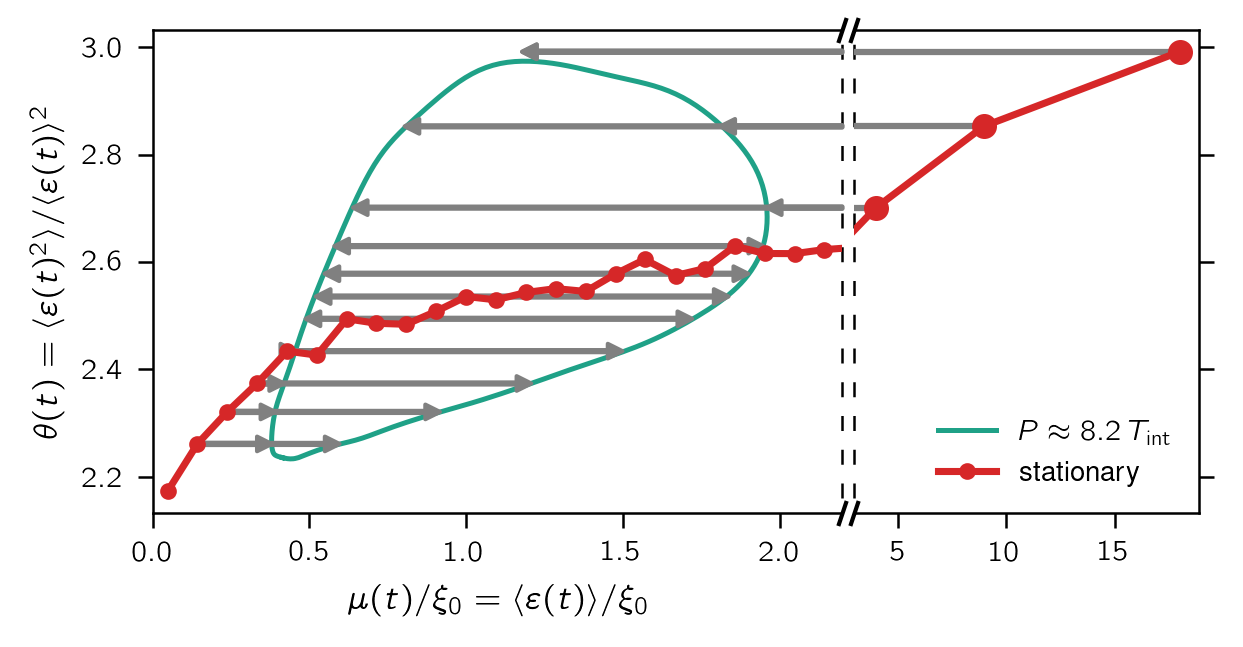

In [5]:
# select simulation and filter size
vkey = 8
V = varsim_list[vkey]
filter_fraction = 64 # filter width is P/filter_fraction
fwidth = np.maximum(V.get_period()/filter_fraction, ref.tauK/4)
t_vals = np.linspace(0, V.get_period(), 256)[:-1]

# set up figure parameters
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(0.75*textwidth, 0.4*textwidth),
    sharey='row', gridspec_kw={'width_ratios':[0.5, 0.25]})
fig.get_layout_engine().set(rect=(0.005, 0., 1., 0.96))
fig.get_layout_engine().set(w_pad=0.02, wspace=0.02)

color = viridis(1 - (vkey-5)/(len(varsim_list) - 5 - 1))
lw = 1.7 # line width
small_markers = 3.
large_markers = 5.
xlimmax = 2.2

# compute TrS2/dissipation moments of oscillating simulation
vTrS2_mom2 = V.periodic_filter(V.statistics['moments/TrS2'][:,2], t_vals, fwidth, transient)
vTrS2_mean = V.periodic_filter(V.statistics['moments/TrS2'][:,1], t_vals, fwidth, transient)
vdiss = V.periodic_filter(V.statistics['diss(t)'], t_vals, fwidth, transient)
vdissmom2norm = vTrS2_mom2/vTrS2_mean**2 # normalized 2nd moment of dissipation

# compute TrS2/dissipation moments of stationary ensemble
ediss = enssim.get_time_averaged_ensemble_stat('diss(t)', transient)
eTrS2moments = enssim.get_time_averaged_ensemble_stat('moments/TrS2', transient)
edissmom2norm = eTrS2moments[:,2]/eTrS2moments[:,1]**2 # normalized 2nd moment of dissipation

## main plot
plt.sca(axs[0])

# plot oscillating and stationary data
plt.plot(close_loop(vdiss)/ref.injrate,
    close_loop(vdissmom2norm), c = color, zorder=1,
    label = r'$P \approx {}\,T_\mathrm{{int}}$'.format(np.round(V.get_period()/ref.Tint, 1)))
plt.plot(ediss/ref.injrate, edissmom2norm, marker='o', markersize=small_markers,
    lw=lw, color='tab:red', label='stationary', zorder=100)

# split closed curve into left branch and right branch
tmin = t_vals[np.argmin(vdissmom2norm)]
tmax = t_vals[np.argmax(vdissmom2norm)]
if tmax > tmin:
    maskright = np.logical_or(t_vals >= tmax, t_vals <= tmin)
    maskleft = np.logical_and(t_vals <= tmax, t_vals >= tmin)
else:
    maskright = np.logical_and(t_vals >= tmax, t_vals <= tmin)
    maskleft = np.logical_or(t_vals <= tmax, t_vals >= tmin)

## plot arrows
# For visualization purposes, we plot (at most) one arrow per stationary
# simulation and branch of the closed curve. The actual computation of the
# fluctuating dissipation ensemble works by putting the oscillating data
# into 2-dimensional bins and then matching them as well as possible with
# the stationary data (see postprocessing.superposition.compute_fluctdiss_weights).
ypos_arrows = []
for mkey, (mdiss, mdissmom2norm) in enumerate(zip(ediss, edissmom2norm)):
    # do not plot arrows if they are too close to each other
    if (np.abs(mdissmom2norm - np.array(ypos_arrows)) > 0.03).all():
        ypos_arrows.append(mdissmom2norm)
        distleft = np.abs(vdissmom2norm[maskleft] - mdissmom2norm)
        # only plot if close enough to the curve
        if len(distleft) > 0 and np.amin(distleft) < 0.05:
            plt.annotate('',
                xy = (vdiss[maskleft][np.argmin(distleft)]/ref.injrate, mdissmom2norm),
                xytext = (np.minimum(mdiss/ref.injrate, xlimmax), mdissmom2norm),
                arrowprops = {'width': 0.5, 'headwidth': 3.5, 'headlength': 3.5, 'color':'grey'})
        distright = np.abs(vdissmom2norm[maskright] - mdissmom2norm)
        # only plot if close enough to the curve
        if len(distright) > 0 and np.amin(distright) < 0.05:
            plt.annotate('',
                xy = (vdiss[maskright][np.argmin(distright)]/ref.injrate, mdissmom2norm),
                xytext = (np.minimum(mdiss/ref.injrate, xlimmax), mdissmom2norm),
                arrowprops = {'width': 0.5, 'headwidth': 3.5, 'headlength': 3.5, 'color':'grey'})

# range and labels
plt.ylabel(r'$\theta(t) =\langle \varepsilon(t)^2 \rangle / \langle \varepsilon(t) \rangle^2$')
plt.xlabel(r'$\mu(t)/\xi_0 = \langle \varepsilon(t) \rangle/ \xi_0$')
plt.xlim(0, xlimmax)
handles, labels = axs[0].get_legend_handles_labels()
axs[1].legend(handles, labels, loc='lower right', frameon=False) 

## extension for extra simulations
plt.sca(axs[1])
plt.plot(ediss/ref.injrate, edissmom2norm, marker='o', markersize=large_markers,
    lw=lw, color='tab:red', label='stationary', zorder=100)
plt.hlines(edissmom2norm, 0, ediss/ref.injrate, color='grey', lw=1.5, zorder=10)
plt.gca().yaxis.tick_right()
plt.gca().tick_params(labelright=False)

# broken x-axis
axs[0].spines['right'].set_linestyle((7, (5, 8.5)))
axs[1].spines['left'].set_linestyle((7, (5, 8.5)))
d = 3.  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=6, zorder=50,
            linestyle="none", color='k', mec='k', mew=1, clip_on=False)
line, = axs[0].plot([1, 1], [1, 0], transform=axs[0].transAxes, **kwargs)
line.set_in_layout(False)
line, = axs[1].plot([0, 0], [0, 1], transform=axs[1].transAxes, **kwargs)
line.set_in_layout(False)
plt.xlim(left=3.);